In [268]:

# Assignment 3
# Determining and removing drawbacks of exponential and running mean.
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Iaroslav Okunevich
#     Nikita Mikhailovskiy
#
# Skoltech, 04.10.2019

import os
try:
	os.chdir(os.path.join(os.getcwd(), 'lab3'))
	print(os.getcwd())
except:
	pass

import numpy as np
from functools import partial

import smoothing as sm
from walking_model import Random_walking_model, rvm_alpha

from noised_signal import Measurements

In [269]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# from plotting import new_plot, draw_plots

def draw_plots(plots=[], show=False):
    for pi, plabel in plots:
        plt.plot(pi, label=plabel)

    plt.legend()
    if show:
        plt.show()


def new_plot(title, xl, yl, plots=[], show=False):
    figure(num=None, figsize=(10, 5), dpi=200,
           facecolor='w', edgecolor='k')
    plt.title(title)
    plt.grid()
    plt.ylabel(yl)
    plt.xlabel(xl)
    if plots:
        draw_plots(plots, show)

In [270]:
def Trajectory(size, X0, t, sigma_a, show = False):
    acc = np.random.normal(X0[2], sigma_a, size - 1)
    vel = Random_walking_model.TrueTrajectory(X0[1], acc * t)
    trajectory = Random_walking_model.TrueTrajectory(
        X0[0], vel[:-1]*t + acc * t * t / 2)
    if show:
        return [[acc, 'acc'], [vel, 'vel']], trajectory
    return trajectory

initial_vals = [5, 1, 0]
size = 200
T = 1
sigma_a = 0.2

gen_Trajectory = partial(Trajectory, size, initial_vals, 1, sigma_a)

#     new_plot('Plot result', 'Measurement', 'Points',
#     [
#         [acc, 'Acceleration'],
#         [vel, 'Velosity']
#     ], show = False)
#     plt.savefig(fname='Trajectory.png')

In [271]:
traject = gen_Trajectory()

sigma_noise = 20
Known_vals = Measurements(traject, sigma_noise)
z = Known_vals.z

# RM = sm.RunningMean(z, 1)

In [272]:
T = 1

# input matrix
G = np.matrix([[T**2/2], [T]])

# obseravation matrix
H = np.matrix([1, 0])

# transition matrix
F = np.matrix([[1, T],[0, 1]])

In [273]:
# covariance matrix Q of state noise Ga i−1
q_pred = np.dot(G, G.T) * sigma_a**2
# sigma_a
print(q_pred, G)

[[0.01 0.02]
 [0.02 0.04]] [[0.5]
 [1. ]]


In [274]:
# covariance matrix R of measurements noise η i

# Dimension of covariance
# matrix R is determined by a number of state vector 
# components that are measured. In this
# particular case, only coordinate x i is measured

R = sigma_noise**2

In [275]:
# initial state vector
X0 = np.matrix([[2], [0]])

# initial filtration error covariance matrix
P00 = np.matrix(np.eye(2) * 10000)

In [291]:

F7 = np.eye(2)
for i in range(6):
    F7 = F7.dot(F)
print(F7)

def recurrent_calman_filter(X0, P0, F, Q, H, R, z, k_koef = 1):
    """
    Recurrent algorithm of Kalman filter
    X0 - initial estimate of state vector
    P0 - initial filtration error covariance matrix
    H - obseravation matrix
    F - transition matrix
    Q - covariance matrix of state noise
    R - covariance matrix of measurements noise η
    """
    size = z.shape[0]
    
    def kalman_predict(x_filt, p_filt, F, Q):
        x_pred = np.dot(F, x_filt)    
        p_pred = np.dot(F.dot(p_filt), F.T) + Q
        return x_pred, p_pred


    def kalman_filter(x_pred, p_pred, z, H, R):
        def correct_coeff():
            x = np.dot(H.dot(p_pred), H.T) + R
            try:
                inverse = np.linalg.inv(x)
            except np.linalg.LinAlgError:
                raise BaseExceptoin
            ki = np.dot(p_pred, H.T).dot(inverse)
            print("ki",ki)
            return ki * k_koef
        
        ki = correct_coeff()
        residual = np.subtract(z, H.dot(x_pred))
        x_filt = x_pred + ki * residual
        p_filt = (np.subtract(np.eye(2), np.dot(ki, H)).dot(p_pred))
        return x_filt, p_filt, ki[0][0]
    
    x_filt = X0
    p_filt = P0

    gain = []
    smoothed = [X0]
    ex7 = []
    
    diag1 = []
    for i in range(size):
        x_pred, p_pred = kalman_predict(x_filt, p_filt, F, q_pred)
        x_filt, p_filt, k = kalman_filter(x_pred, p_pred, z[i], H, R)
        smoothed.append(x_filt)
        gain.append(k)
        diag1.append(np.sqrt(p_filt[0,0]))
    return np.array(smoothed), gain, diag1

# Plot results including 
# true trajectory, measurements, 
# filtered estimates of state vector X i .
smoothed, gain, daig1 = \
recurrent_calman_filter(X0[:2], P00, F, q_pred, H, R, z)

z_res7 = [np.dot(F7,si)[0][0] for si in smoothed]
# print(z_res7)


[[1. 6.]
 [0. 1.]]
ki [[0.98039217]
 [0.49019682]]
ki [[0.93632993]
 [0.84269901]]
ki [[0.80819204]
 [0.46696492]]
ki [[0.68722586]
 [0.28839755]]
ki [[0.59238137]
 [0.19470928]]
ki [[0.51880155]
 [0.14006679]]
ki [[0.46080291]
 [0.10555649]]
ki [[0.41418577]
 [0.08241902]]
ki [[0.37602879]
 [0.0661773 ]]
ki [[0.34429626]
 [0.05435647]]
ki [[0.31754532]
 [0.04549996]]
ki [[0.29473227]
 [0.03870579]]
ki [[0.27508689]
 [0.03339139]]
ki [[0.25803001]
 [0.02916693]]
ki [[0.24311864]
 [0.02576356]]
ki [[0.2300087 ]
 [0.02299099]]
ki [[0.21842906]
 [0.0207114 ]]
ki [[0.20816335]
 [0.01882297]]
ki [[0.19903674]
 [0.01724906]]
ki [[0.19090632]
 [0.01593107]]
ki [[0.18365398]
 [0.0148235 ]]
ki [[0.17718098]
 [0.01389051]]
ki [[0.1714039 ]
 [0.01310352]]
ki [[0.16625142]
 [0.01243946]]
ki [[0.16166188]
 [0.01187947]]
ki [[0.15758138]
 [0.01140798]]
ki [[0.15396222]
 [0.01101199]]
ki [[0.15076174]
 [0.01068056]]
ki [[0.14794138]
 [0.01040439]]
ki [[0.14546598]
 [0.0101755 ]]
ki [[0.14330318]
 [0.

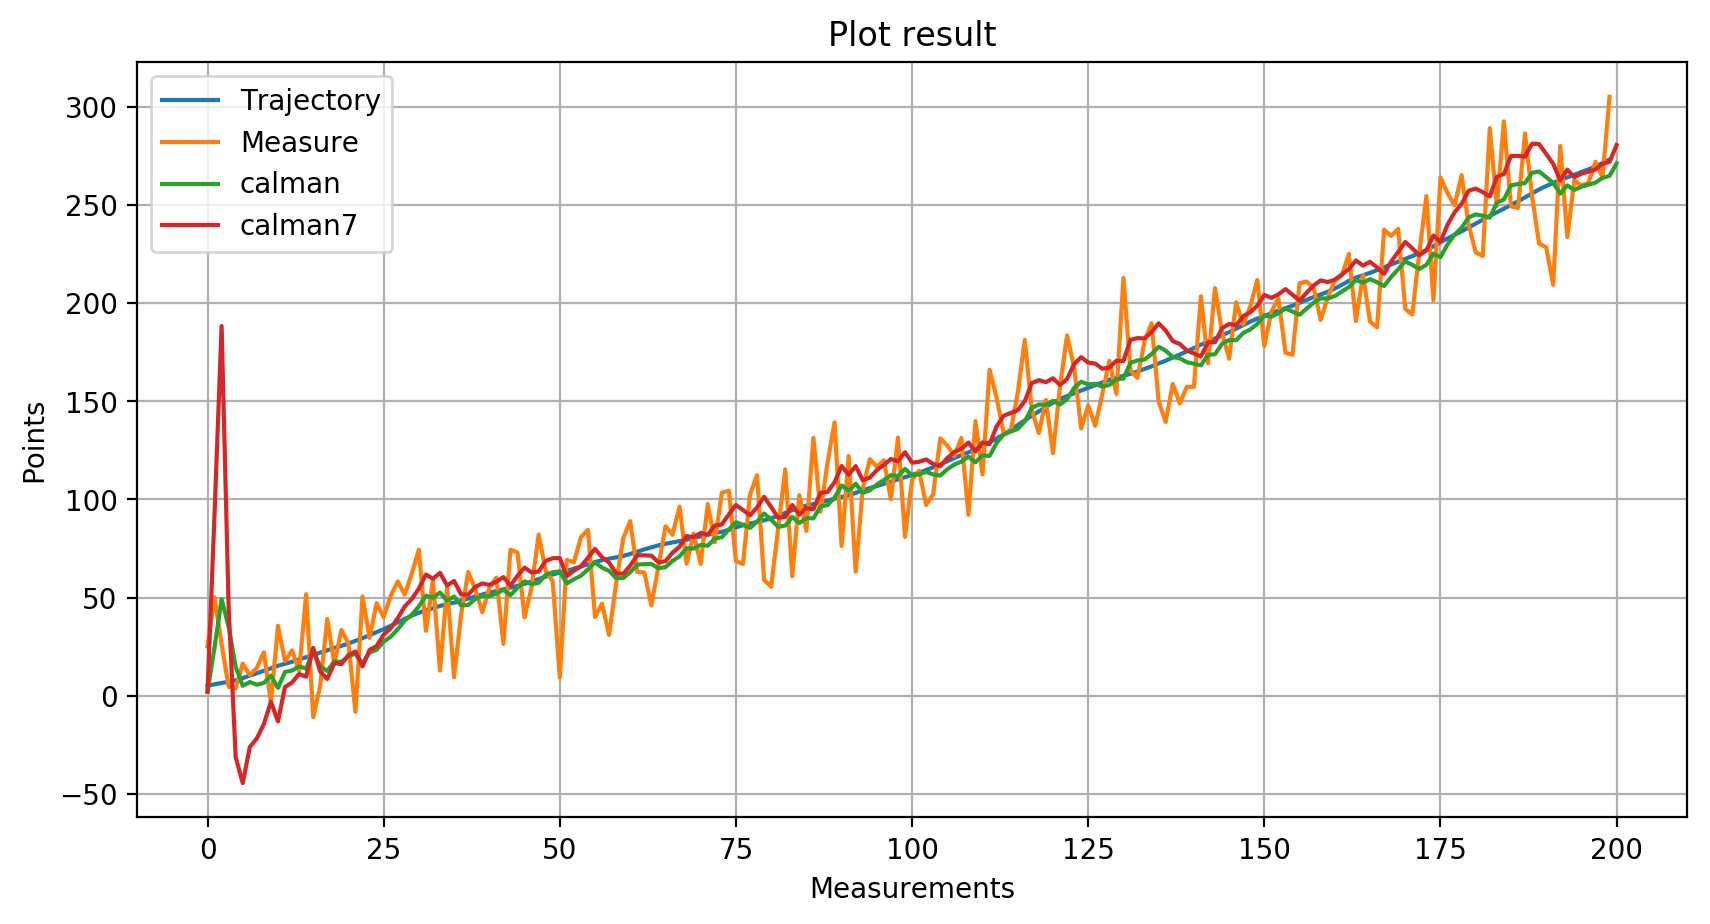

In [277]:
xs = smoothed.squeeze()
z_res7 = np.array(z_res7).squeeze()


new_plot('Plot result',
        'Measurements', 'Points', [
            [traject, 'Trajectory'],
            [z, 'Measure'],
            [xs[:,0], 'calman'],
            [z_res7, 'calman7']
        ], show = False)
plt.savefig(fname = 'running mean 1.png')

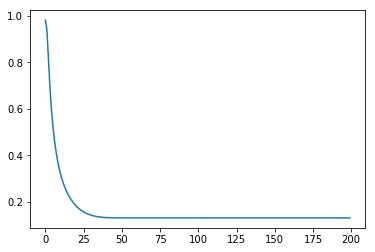

In [278]:
gs = np.array(gain).squeeze()
plt.plot(gs)
plt.show()
# new_plot('',
#         'gain', 'Points', [
#             [gs, 'gain (ki)']
#         ], show = True)
# plt.savefig(fname = 'running mean 1.png')

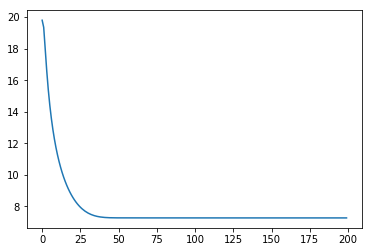

In [279]:
# To analyze filtration error covariance matrix P i,i over observation period, please also make
# another plot of square root of its first diagonal element corresponding to standard deviation
# of estimation error of coordinate x i .
daig1_plot = np.array(daig1).squeeze()

# Verify whether filter gain K and filtration error covariance matrix become constant very
# quickly. It means that in conditions of a trajectory disturbed by random noise we cannot
# estimate more than established limit of accuracy due to uncertainty.

plt.plot(daig1_plot)
plt.show()

In [280]:
runs = 500
n = size

gen_Trajectory = partial(Trajectory, n, initial_vals, 1, sigma_a)


def proc_exp(func):
    x = gen_Trajectory()
    kvals = Measurements(x, sigma_noise)
    z = kvals.z
    
    s1, gain, daig1 = recurrent_calman_filter(X0, P00, F, q_pred, H, R, kvals.z)
    s7 = np.array([np.dot(F7,si) for si in s1[:-1]])
    
    z_res1 = s1.squeeze()[1:,0]
    z_res7 = s7[:,0,0]

    return z, z_res1, z_res7, x

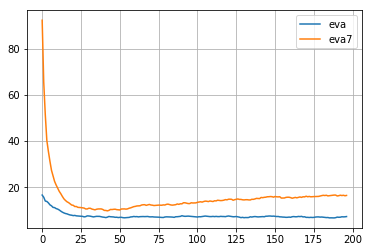

In [281]:
recurrent_calman_filter_part = partial(recurrent_calman_filter, X0, P00, F, q_pred, H, R)
    
errs1 = np.zeros(n)
errs7 = np.zeros(n)
for i in range(runs):
    z, s1, s7, x = proc_exp(recurrent_calman_filter_part)
    errs1 += (x - s1)**2
    errs7 += (x - s7)**2

eva1 = np.sqrt(errs1[3:] / (runs - 1))
eva7 = np.sqrt(errs7[3:] / (runs - 1))

# new_plot('',
#         'Predict error', 'Points', [
#             [eva7, "eva7"],
#             [eva1, "eva"]
#         ], show = True)

plt.plot(eva1, label="eva")
plt.plot(eva7, label="eva7")
plt.legend()
plt.grid()
# plt.show()

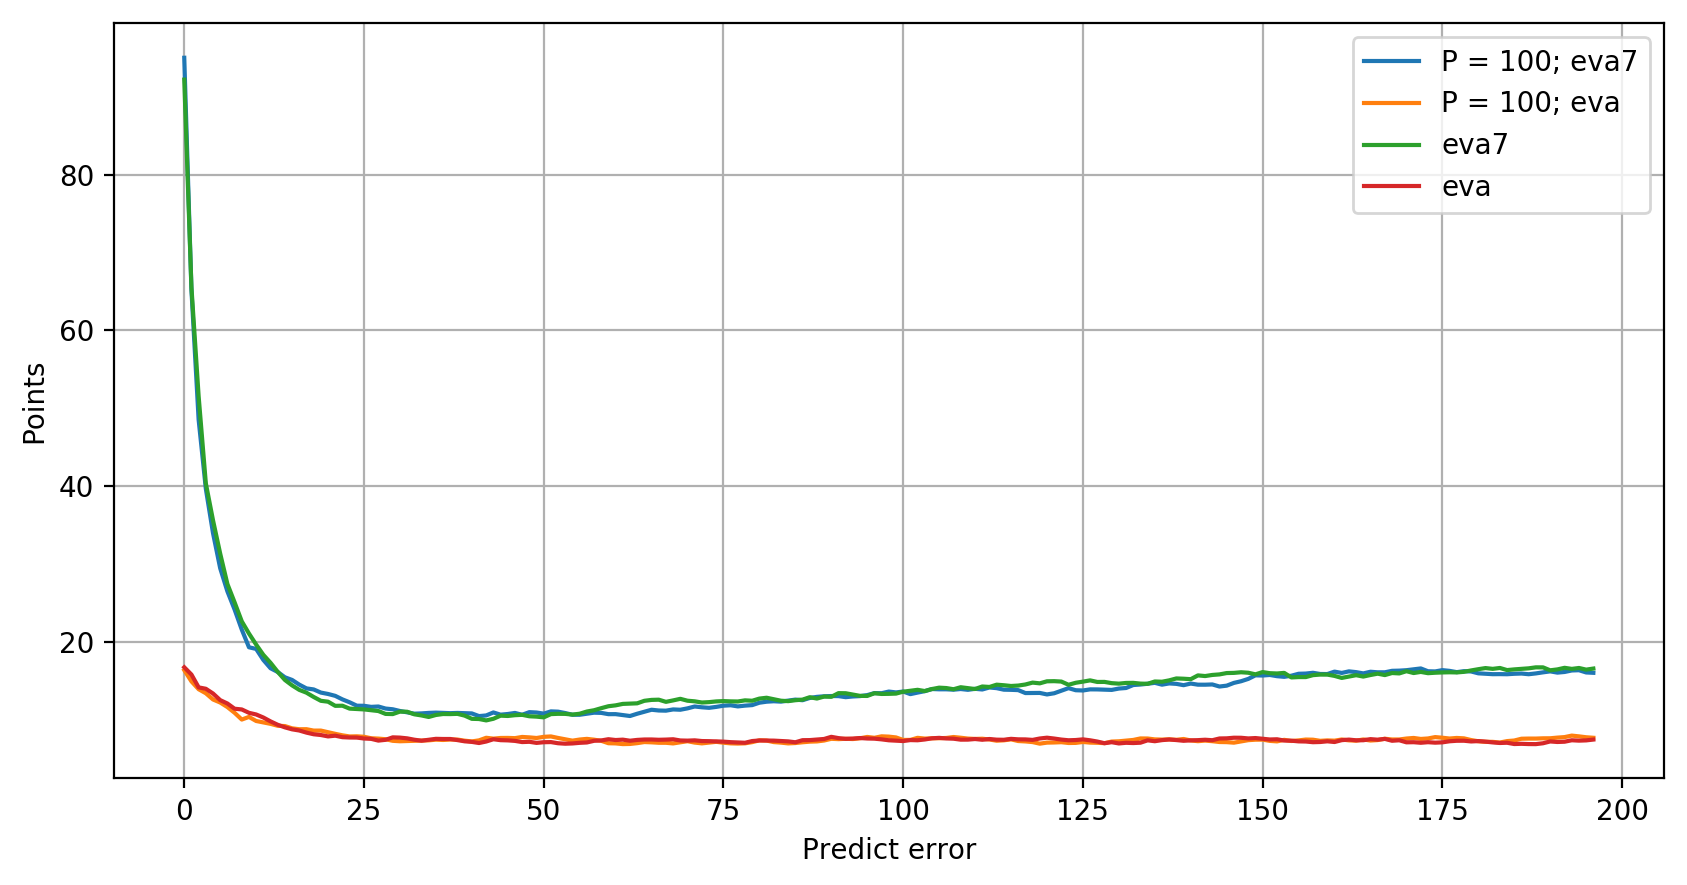

In [282]:
# initial filtration error covariance matrix
P1 = np.matrix(np.eye(2) * 100)

recurrent_calman_filter_part2 = partial(recurrent_calman_filter, X0, P1, F, q_pred, H, R)
    
errs1 = np.zeros(n)
errs7 = np.zeros(n)
for i in range(runs):
    z, s1, s7, x = proc_exp(recurrent_calman_filter_part2)
    errs1 += (x - s1)**2
    errs7 += (x - s7)**2

eva1_1 = np.sqrt(errs1[3:] / (runs - 1))
eva1_7 = np.sqrt(errs7[3:] / (runs - 1))

new_plot('',
        'Predict error', 'Points', [
            [eva1_7, "P = 100; eva7"],
            [eva1_1, "P = 100; eva"],
            [eva7, "eva7"],
            [eva1, "eva"]
        ], show = True)

# plt.plot(eva1, label="eva")
# plt.plot(eva7, label="eva7")
# plt.plot(eva1_1, label="P = 100; eva")
# plt.plot(eva1_7, label="P = 100; eva7")
# plt.legend()
# plt.grid()
# plt.show()

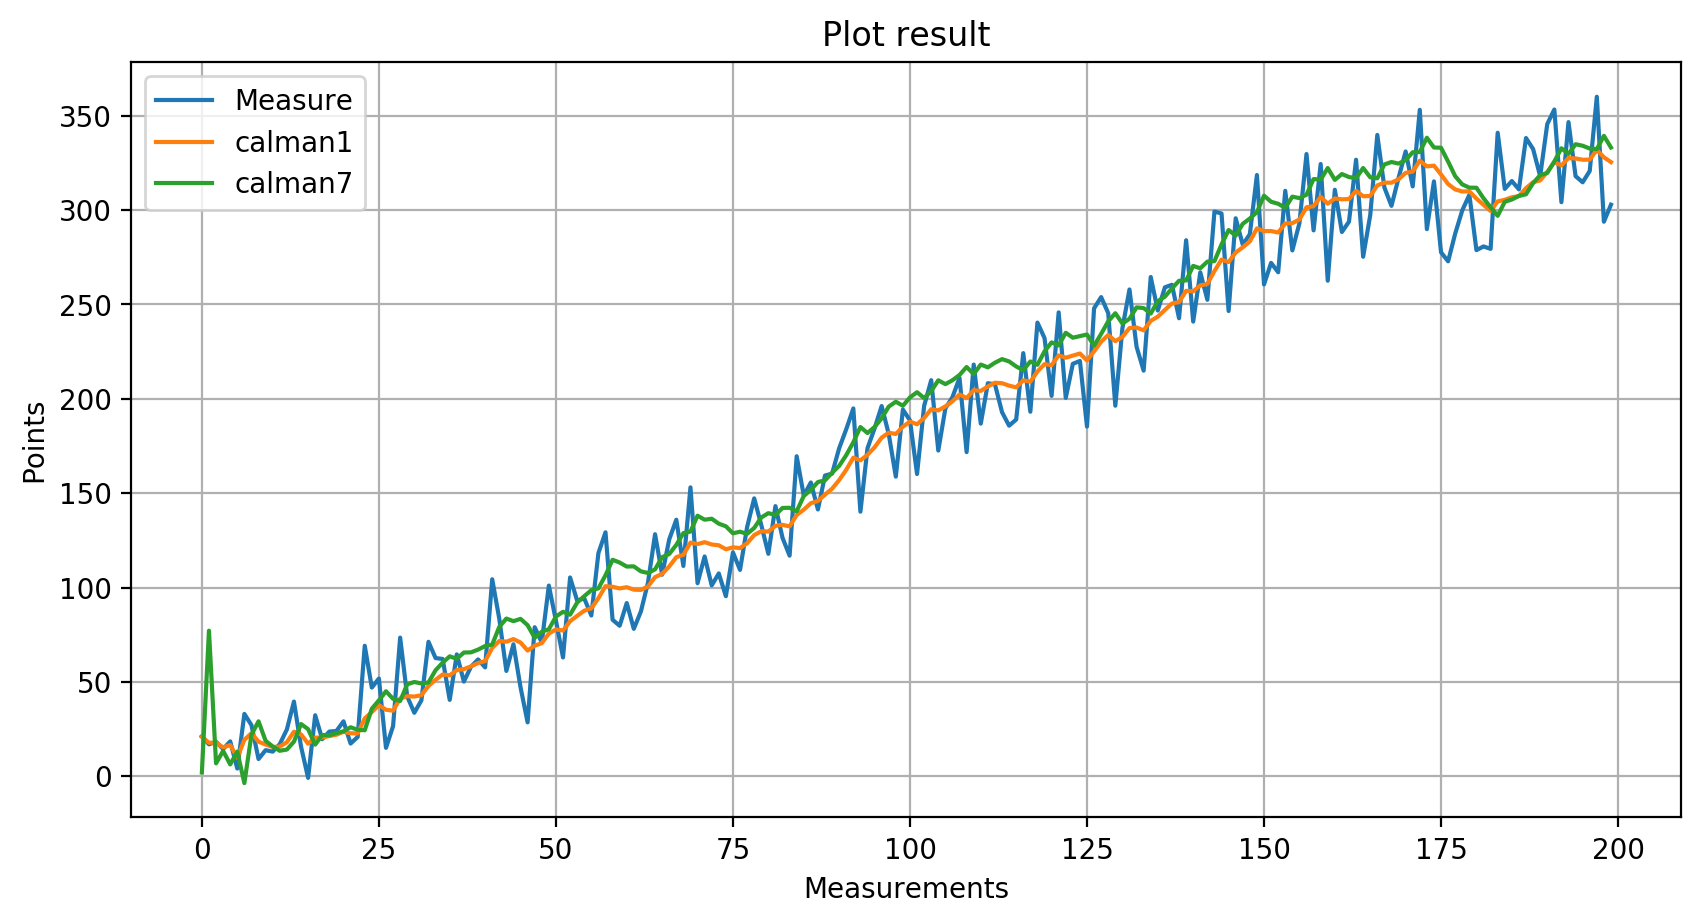

In [283]:

# plt.savefig(fname = 'running mean 1.png')
    
new_plot('Plot result',
        'Measurements', 'Points', [
#             [traject, 'Trajectory'],
            [z, 'Measure'],
            [s1, 'calman1'],
            [s7, 'calman7'],
        ], show = True)
# plt.savefig(fname = 'running mean 1.png')

In [287]:
# k divide by 5
koef = 1. / 5.

# X02 = X0
X02 = np.matrix([[100], [5]])

recurrent_calman_filter_part3 = partial(recurrent_calman_filter, X02, P00, F, q_pred, H, R, k_koef = 1.)
recurrent_calman_filter_part4 = partial(recurrent_calman_filter, X02, P00, F, q_pred, H, R, k_koef = koef)
# recurrent_calman_filter_part3 = partial(recurrent_calman_filter_part2, koef)

# recurrent_calman_filter(X0, P00, F, q_pred, H, R, koef)

def check_mean_square_err(run, n, runs):
    err1 = np.zeros(n)
#     err7 = np.zeros(n)
    
    for i in range(runs):
        z, s1, s7, x = proc_exp(run)
        err1 += (x - s1)**2
#         err7 += (x - s7)**2

    e1 = np.sqrt(err1[3:] / (runs - 1))
#     e7 = np.sqrt(err7[3:] / (runs - 1))
    return e1


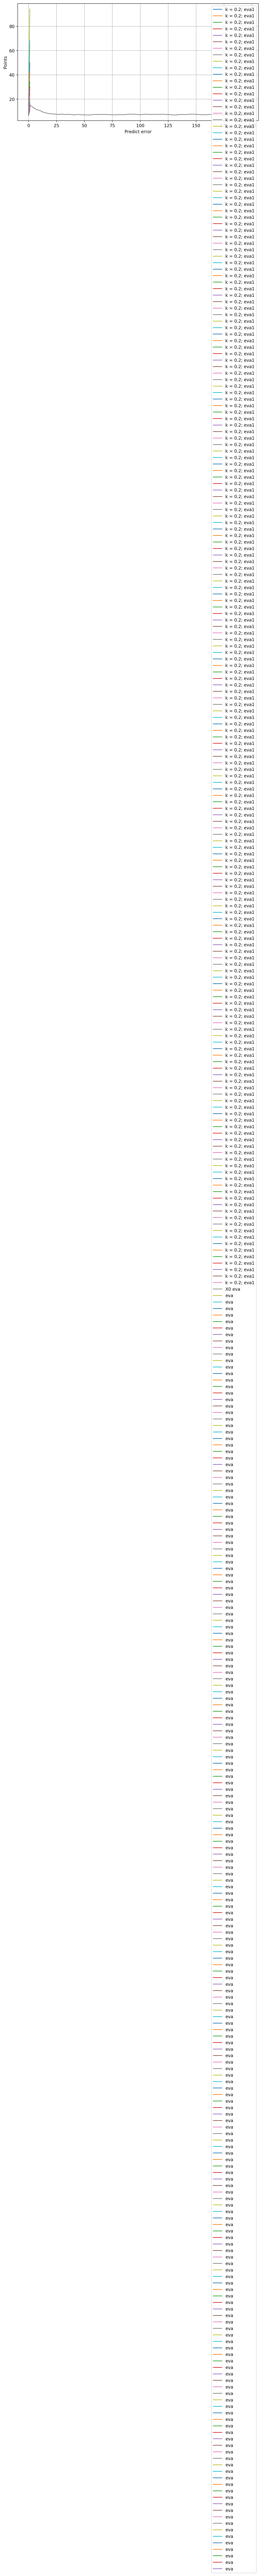

In [289]:
e1 = check_mean_square_err(recurrent_calman_filter_part3, n, runs)
eva1_1 = check_mean_square_err(recurrent_calman_filter_part4, n, runs)

new_plot('',
        'Predict error', 'Points', [
#             [eva1_7, "k = 0.2; eva7"],
            [eva1_1, "k = 0.2; eva1"],
#             [eva7, "X0 eva7"],
            [eva1, "X0 eva"],
#             [e7, "eva7"],
            [e1, "eva"]
        ], show = True)  